# Notebook Description

In this Notebook we create our Neural Network. It will consist of three main parts:
- Embedding Layer
- Transformer Encoder
- Action-Pointer Decoder

First, we will implement our created data into a training, validation and test set of the according form.<br>
Then, we create the architecture of our Neural Network.<br>
Afterwards, we compile it and define a custom loss function and metric.<br>
Finally, we will train, validate and test it.<br>

# Code

In [1]:
import numpy as np
import os
import pickle
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LSTM, Concatenate, LeakyReLU, Softmax, Dropout, Add
from keras.layers import Lambda, Flatten, Bidirectional, TimeDistributed, Reshape, MultiHeadAttention, LayerNormalization
from keras.activations import tanh
from keras.models import Model, Sequential
import keras.backend
import random
from copy import copy
#import necessary notebooks
import import_ipynb
from Jobs_and_Machines import *
from States_and_Policies import *
from Action_Pointer import *

importing Jupyter notebook from Jobs_and_Machines.ipynb
importing Jupyter notebook from States_and_Policies.ipynb
importing Jupyter notebook from Global_Variables.ipynb
importing Jupyter notebook from Action_Pointer.ipynb


In [2]:
#change working directory
work_path = input("Working directory to save the Neural Network.\n")
os.chdir(work_path)

Working directory to save the Neural Network.
D:\\Job-Scheduling-Files


### Create Training, Validation and Test Data

Define the minimum and maximum amount of Jobs and Machines on which the Network shall be trained.<br>
Give the range of datasets (<i>DS</i>) that shall be used for training. Every such dataset contains the data of 10.000 different Job Scheduling Problems.

In [3]:
#max jobs
n = 8
#min jobs
n_min = 3

#max machines
m = 4
#min machines
m_min = 2

#datasets used
DS_max = 10
DS_min = 1

We now have to load the data from the respective dataset to create our training, validation and test data.<br>
For each of them, the data set will be divided into subsets, corresponding to a key <i>(n_state,m_state)</i> of how many Jobs <i>n_state</i> and how many Machines <i>m_state</i> remain in the state from which the data was extracted.

In [4]:
def load_data(DS_min,DS_max):
    
    #dictionary will contain data from all respective data sets
    data_dict = dict(((n_state,m_state),[[],[]]) 
                           for n_state in range(n_min,n+1) for m_state in range(m_min,m+1))
    
    #load data
    for n_state in range(n_min, n+1):
        for m_state in range(m_min, m+1):
            #resource information of the jobs: processing time on every machine and its metadata
            x_res = []
            #urgency information of the jobs: earliness and weight
            x_urg = []
            #targets
            y = []
            #loop over every data set "DS"
            for DS in ["0"*(2-len(str(i)))+str(i) for i in range(DS_min,DS_max+1)]:
                training_data_path = f'Data/DataSet_{DS}/LSTM_Data_RR_{DS}/{n_state}-jobs-{m_state}-machines_{DS}.pickle'
                with open(training_data_path, 'rb') as f:
                    #load data set of key (n_state,m_state)
                    data = pickle.load(f)
                    #get data about its resources for every job of one state of one Job Scheduling Problem
                    jobs_resources = data[0][0][:,:,:-2].reshape((-1,n_state,m_state,4))
                    #get data abouts its urgenicies for every job  of one state of one Job Scheduling Problem
                    jobs_urgencies = data[0][0][:,:,-2:]
                    #add to data of states of other Job Scheduling Problems
                    x_res.append(jobs_resources)
                    x_urg.append(jobs_urgencies)
                    y.append(data[1][0])
            #transform list of data from states of Job Scheduling Problems to numpy array and add to final data dictionary
            data_dict[(n_state,m_state)][0].append(np.concatenate(x_res))
            data_dict[(n_state,m_state)][0].append(np.concatenate(x_urg))
            data_dict[(n_state,m_state)][1].append(np.concatenate(y))
            
    return data_dict

In [5]:
training_dict = load_data(DS_min,DS_max)
validation_dict = load_data(98,98)
test_dict = load_data(99,99)

Next we have to split the data of every <i>(n_state,m_state)</i>-subset from the data dictionaries into a list of inputs and a list of targets.

In [6]:
x_train_list, y_train_list = [], []
x_val_list, y_val_list = [], []
x_test_list, y_test_list = [], []

for key in training_dict:
    #training data
    x_train, y_train = training_dict[key]
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    
    #validation data
    x_val, y_val = validation_dict[key]
    x_val_list.append(x_val)
    y_val_list.append(y_val)
    
    #test data
    x_test, y_test = test_dict[key]
    x_test_list.append(x_test)
    y_test_list.append(y_test)

We have <i>\[n-(n_min-1)\] * \[m-(m_in-1)\] = 18</i> such subsets.<br>
<br>

Since every dataset DS contained 10.000 Job Scheduling Problems, our training data now consists of<br>

<i>\[DS_max-(DS_min-1)\] * 10.000 = 10 * 10.000 = 100.000</i><br>
data instances for every subset, so in total we have<br>

<i>18 * 100.000 = 1.800.000</i><br>

data samples in our training set.<br>
<br>

The validation and test consist of<br>

<i>18 * 10.000 = 180.000</i><br>

data samples each.

### Build Neural Network

In [7]:
"""Inputs"""
inputs_resources = keras.Input(shape=(None,None,4), name="Job Resources")
inputs_urgencies = keras.Input(shape=(None,2), name="Job Urgencies")

"""Embedding Jobs"""
    #feed every element of a job into an LSTM to obtain job-representation of fixed dimension
x_res = TimeDistributed(Bidirectional(LSTM(16),name="bidirectional1"),name="LSTM_resources")(inputs_resources)
x_res = FeedForward(16,16, name="FF_resources")(x_res)

    #apply self-attention to urgencies of jobs to transform into context-related urgencies
x_urg = FeedForward(4,4, name="FF1_urgencies")(inputs_urgencies)
x_urg = MultiHeadAttention(num_heads=2, key_dim=8, name="Self-Attention_urgencies")(x_urg, x_urg)
x_urg = FeedForward(4,4, name="FF2_urgencies")(x_urg)

    #concatenate both information for every job to obtain embedded representation for every job
x_emb = Concatenate(name="concat_input")([x_res,x_urg])
x_emb = FeedForward(16,16, name="FF_embed")(x_emb)

"""Transformer Encoder"""
    #apply Transformer Self-Attention to jobs to turn their representation context related
x = MultiHeadAttention(num_heads=4, key_dim=32, name="Encoder_Self-Attention")(x_emb,x_emb)
x = Add(name="Residual_Connection_1")([x,x_emb])
x_enc = FeedForward(16,16, name="FF_encoder")(x)
x_enc = Add(name="Residual_Connection_2")([x_enc,x])

"""Action-Pointer Decoder"""
    #pass encoded jobs through bottom LSTM to create context job-based representation of action of assigning the representive job
actions, fwrd_h, fwrd_c, bwrd_h, bwrd_c = Bidirectional(LSTM(32, return_sequences=True, return_state=True, name="bidirectional2"),name="Decoder_Bottom_LSTM")(x_enc)

    #use last hidden state of bottom LSTM to create representation of action of deactivating currently free machine
h = Concatenate(name="concat_final_hidden_states")([fwrd_h,bwrd_h])
action_shtdwn = Reshape((1,-1))(FeedForward(64,64, name="FF_shut")(h))

    #actions of job assignments together with machine shutdown are keys for Pointer
keys = Concatenate(axis=1, name="concat_actions")([actions,action_shtdwn])

    #use memory states of bottom LSTM to initiate top LSTM
h_f = FeedForward(32,32, name="FF_h_frwd")(fwrd_h)
c_f = FeedForward(32,32, name="FF_h_bwrd")(fwrd_c)
h_b = FeedForward(32,32, name="FF_c_frwd")(bwrd_h)
c_b = FeedForward(32,32, name="FF_c_bwrd")(bwrd_c)
mem_states = [h_f, c_f, h_b, c_b] 

    #query of Pointer is final hidden state of top LSTM which has all the state information immanent
x_dec = Bidirectional(LSTM(32, name="bidirectional3"),name="Decoder_Pointer_LSTM")(keys, initial_state=mem_states)
query = FeedForward(128,128)(x_dec)

"""Outpput"""
    #output are the attentions that the Network pays to every feasible action given the entire state information
output = Pointer(128)(keys,query)

"""Model"""
Neural_Network = keras.Model(inputs=[inputs_resources,inputs_urgencies], outputs=output)

In [8]:
Neural_Network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Job Urgencies (InputLayer)     [(None, None, 2)]    0           []                               
                                                                                                  
 Job Resources (InputLayer)     [(None, None, None,  0           []                               
                                 4)]                                                              
                                                                                                  
 FF1_urgencies (FeedForward)    (None, None, 4)      32          ['Job Urgencies[0][0]']          
                                                                                                  
 LSTM_resources (TimeDistribute  (None, None, 32)    2688        ['Job Resources[0][0]']      

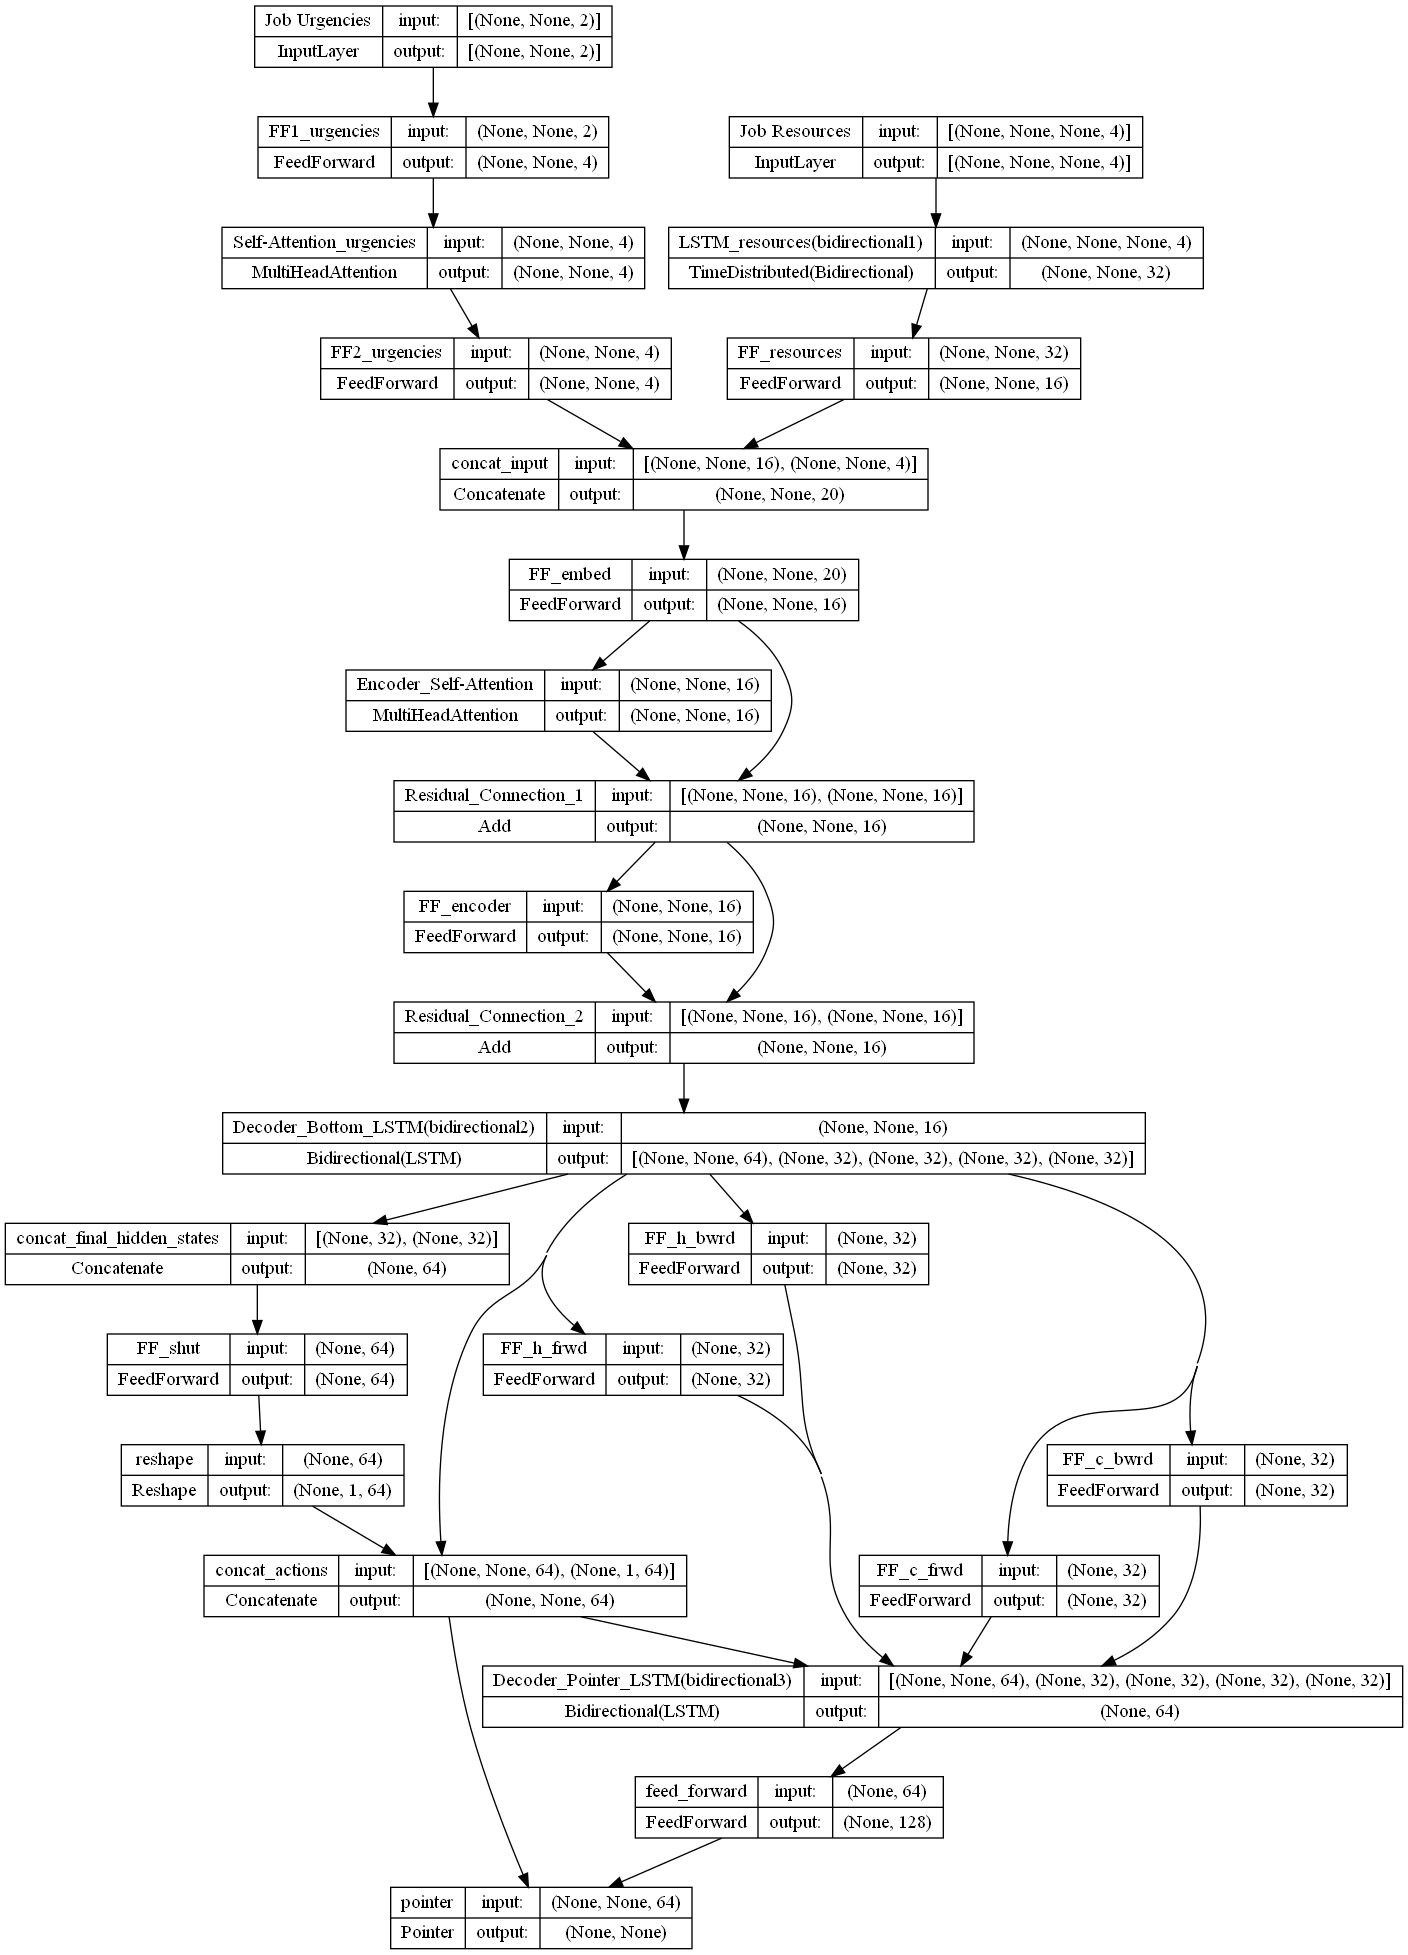

In [9]:
keras.utils.plot_model(Neural_Network, 'Neural_Network.png', show_shapes=True)

### Compile Model

Now we can choose our learning reate and compile our model. We will use Adam as an optimizer.

In [10]:
learning_rate = 0.001

Neural_Network.compile(
        #custom loss
        loss = MSE_with_Softmax,
        #optimizer
        optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
        run_eagerly=True,
        #custom metric
        metrics = [costs])

### Training and Validation

Now we have everything to train our model. One epoch will consist of the states related to one <i>(n_state,m_state)</i>-subset only. Therefore, to see the entire training data, we need<br>

<i>\[n-(n_min-1)\] * \[m-(m_min-1)\] = 18</i><br>

epochs. We will do 30 such loops, so the total number of training epochs will be

<i>18 * 30 = 540</i><br>

After every 10 loops, we will check the performance of the Neural Network on the validation set.

The ordering of these subsets will be shuffled before every loop. Moreover, the training data of one such subset will be divided into random batches of size 128 in every epoch.

#### First 10 loops

In [11]:
print(f"We train on {len(x_train_list)} different n-m-combinations.")
ep=0
#run 10 loops
for i in range(10):
    #shuffle subsets
    zipped_list = list(zip(x_train_list,y_train_list))
    random.shuffle(zipped_list)
    x_train_list, y_train_list = zip(*zipped_list)
    #train one epoch on  every subset
    for j in range(len(x_train_list)):
        history = Neural_Network.fit(x_train_list[j], y_train_list[j], shuffle=True, batch_size=128, epochs=ep+1, initial_epoch=ep) #validation_data=(x_val_list[j],y_val_list[j])) #callbacks=[my_val_callback]
        ep = history.epoch[-1]+1

We train on  18  different n-m-combinations.
782/782 [==============================] - 185s 236ms/step - loss: 61.5021 - costs: 5.3498
Epoch 2/2
782/782 [==============================] - 245s 313ms/step - loss: 11.8586 - costs: 2.9992
Epoch 3/3
782/782 [==============================] - 193s 247ms/step - loss: 32.6428 - costs: 2.2691
Epoch 4/4
782/782 [==============================] - 200s 256ms/step - loss: 13.3986 - costs: 1.6575
Epoch 5/5
782/782 [==============================] - 214s 273ms/step - loss: 7.0350 - costs: 1.4092
Epoch 6/6
782/782 [==============================] - 206s 263ms/step - loss: 17.5013 - costs: 2.0523
Epoch 7/7
782/782 [==============================] - 208s 266ms/step - loss: 6.4790 - costs: 1.3286
Epoch 8/8
782/782 [==============================] - 184s 236ms/step - loss: 11.9425 - costs: 0.8370
Epoch 9/9
782/782 [==============================] - 222s 284ms/step - loss: 2.5117 - costs: 0.7999
Epoch 10/10
782/782 [==============================] - 242s

782/782 [==============================] - 186s 238ms/step - loss: 2.9661 - costs: 0.1860
Epoch 82/82
782/782 [==============================] - 226s 289ms/step - loss: 4.8290 - costs: 0.8960
Epoch 83/83
782/782 [==============================] - 253s 323ms/step - loss: 0.7281 - costs: 0.2355
Epoch 84/84
782/782 [==============================] - 232s 297ms/step - loss: 2.2018 - costs: 0.6363
Epoch 85/85
782/782 [==============================] - 199s 254ms/step - loss: 1.6029 - costs: 0.1919
Epoch 86/86
782/782 [==============================] - 269s 344ms/step - loss: 2.5878 - costs: 0.8492
Epoch 87/87
782/782 [==============================] - 190s 244ms/step - loss: 7.1155 - costs: 0.4626
Epoch 88/88
782/782 [==============================] - 238s 305ms/step - loss: 0.8899 - costs: 0.2825
Epoch 89/89
782/782 [==============================] - 246s 314ms/step - loss: 1.7086 - costs: 0.5778
Epoch 90/90
782/782 [==============================] - 261s 334ms/step - loss: 1.3127 - costs:

In [12]:
#evaluate perfromance on validation set
for j in range(len(x_val_list)):
    print(str(j//3+3), " Jobs ", str(j%3+2), " Machines:")
    performance = Neural_Network.evaluate(x_val_list[j], y_val_list[j])

3  Jobs  2  Machines:
313/313 [==============================] - 37s 117ms/step - loss: 25.4495 - costs: 0.3053
3  Jobs  3  Machines:
313/313 [==============================] - 37s 120ms/step - loss: 15.2175 - costs: 0.4804
3  Jobs  4  Machines:
313/313 [==============================] - 38s 122ms/step - loss: 24.6921 - costs: 0.8126
4  Jobs  2  Machines:
313/313 [==============================] - 39s 126ms/step - loss: 14.7078 - costs: 0.3318
4  Jobs  3  Machines:
313/313 [==============================] - 40s 129ms/step - loss: 5.4326 - costs: 0.2627
4  Jobs  4  Machines:
313/313 [==============================] - 41s 131ms/step - loss: 9.3929 - costs: 0.5797
5  Jobs  2  Machines:
313/313 [==============================] - 41s 132ms/step - loss: 9.7309 - costs: 0.2754
5  Jobs  3  Machines:
313/313 [==============================] - 42s 134ms/step - loss: 2.8595 - costs: 0.3125
5  Jobs  4  Machines:
313/313 [==============================] - 43s 137ms/step - loss: 4.2081 - costs: 0.51

#### Second 10 loops

In [14]:
print(f"We train on {len(x_train_list)} different n-m-combinations.")
ep=10*18
#run 10 loops
for i in range(10):
    #shuffle subsets
    zipped_list = list(zip(x_train_list,y_train_list))
    random.shuffle(zipped_list)
    x_train_list, y_train_list = zip(*zipped_list)
    #train one epoch on  every subset
    for j in range(len(x_train_list)):
        history = Neural_Network.fit(x_train_list[j], y_train_list[j], shuffle=True, batch_size=128, epochs=ep+1, initial_epoch=ep) #validation_data=(x_val_list[j],y_val_list[j])) #callbacks=[my_val_callback]
        ep = history.epoch[-1]+1

We train on  18  different n-m-combinations.
Epoch 181/181
782/782 [==============================] - 217s 278ms/step - loss: 2.3690 - costs: 0.2742
Epoch 182/182
782/782 [==============================] - 224s 287ms/step - loss: 0.8024 - costs: 0.1555
Epoch 183/183
782/782 [==============================] - 239s 305ms/step - loss: 3.2820 - costs: 0.5852
Epoch 184/184
782/782 [==============================] - 239s 306ms/step - loss: 0.6491 - costs: 0.1854
Epoch 185/185
782/782 [==============================] - 254s 324ms/step - loss: 0.4869 - costs: 0.1773
Epoch 186/186
782/782 [==============================] - 254s 325ms/step - loss: 2.6421 - costs: 0.6642
Epoch 187/187
782/782 [==============================] - 206s 264ms/step - loss: 6.7238 - costs: 0.3809
Epoch 188/188
782/782 [==============================] - 269s 344ms/step - loss: 2.1103 - costs: 0.6201
Epoch 189/189
782/782 [==============================] - 210s 269ms/step - loss: 1.1397 - costs: 0.1349
Epoch 190/190
782/7

782/782 [==============================] - 206s 264ms/step - loss: 5.3449 - costs: 0.2873
Epoch 338/338
782/782 [==============================] - 216s 276ms/step - loss: 1.7550 - costs: 0.1939
Epoch 339/339
782/782 [==============================] - 304s 388ms/step - loss: 1.6191 - costs: 0.5044
Epoch 340/340
782/782 [==============================] - 244s 312ms/step - loss: 0.5042 - costs: 0.1458
Epoch 341/341
782/782 [==============================] - 268s 343ms/step - loss: 1.1160 - costs: 0.2966
Epoch 342/342
782/782 [==============================] - 281s 359ms/step - loss: 0.3487 - costs: 0.1311
Epoch 343/343
782/782 [==============================] - 218s 279ms/step - loss: 2.0120 - costs: 0.2215
Epoch 344/344
782/782 [==============================] - 226s 289ms/step - loss: 0.5822 - costs: 0.1132
Epoch 345/345
782/782 [==============================] - 274s 350ms/step - loss: 1.7362 - costs: 0.5086
Epoch 346/346
782/782 [==============================] - 243s 311ms/step - los

In [15]:
#evaluate perfromance on validation set
for j in range(len(x_val_list)):
    print(str(j//3+3), " Jobs ", str(j%3+2), " Machines:")
    performance = Neural_Network.evaluate(x_val_list[j], y_val_list[j])

3  Jobs  2  Machines:
313/313 [==============================] - 36s 116ms/step - loss: 12.5542 - costs: 0.2581
3  Jobs  3  Machines:
313/313 [==============================] - 37s 118ms/step - loss: 4.4163 - costs: 0.2024
3  Jobs  4  Machines:
313/313 [==============================] - 38s 121ms/step - loss: 5.8231 - costs: 0.2451
4  Jobs  2  Machines:
313/313 [==============================] - 38s 123ms/step - loss: 9.4529 - costs: 0.3328
4  Jobs  3  Machines:
313/313 [==============================] - 40s 127ms/step - loss: 3.2300 - costs: 0.2545
4  Jobs  4  Machines:
313/313 [==============================] - 40s 128ms/step - loss: 3.0414 - costs: 0.2395
5  Jobs  2  Machines:
313/313 [==============================] - 40s 129ms/step - loss: 7.4803 - costs: 0.2992
5  Jobs  3  Machines:
313/313 [==============================] - 41s 132ms/step - loss: 3.6108 - costs: 0.4029
5  Jobs  4  Machines:
313/313 [==============================] - 42s 135ms/step - loss: 2.9742 - costs: 0.4018


#### Third 10 loops

In [17]:
print(f"We train on {len(x_train_list)} different n-m-combinations.")
ep=20*18
#run 10 loops
for i in range(10):
    #shuffle subsets
    zipped_list = list(zip(x_train_list,y_train_list))
    random.shuffle(zipped_list)
    x_train_list, y_train_list = zip(*zipped_list)
    #train one epoch on  every subset
    for j in range(len(x_train_list)):
        history = Neural_Network.fit(x_train_list[j], y_train_list[j], shuffle=True, batch_size=128, epochs=ep+1, initial_epoch=ep) #validation_data=(x_val_list[j],y_val_list[j])) #callbacks=[my_val_callback]
        ep = history.epoch[-1]+1

We train on  18  different n-m-combinations.
Epoch 361/361
782/782 [==============================] - 261s 334ms/step - loss: 1.9675 - costs: 0.4909
Epoch 362/362
782/782 [==============================] - 263s 336ms/step - loss: 0.4549 - costs: 0.1542
Epoch 363/363
782/782 [==============================] - 288s 368ms/step - loss: 0.3203 - costs: 0.1198
Epoch 364/364
782/782 [==============================] - 203s 260ms/step - loss: 3.2858 - costs: 0.1943
Epoch 365/365
782/782 [==============================] - 214s 273ms/step - loss: 0.7804 - costs: 0.0909
Epoch 366/366
782/782 [==============================] - 226s 289ms/step - loss: 3.1760 - costs: 0.3222
Epoch 367/367
782/782 [==============================] - 299s 382ms/step - loss: 0.8761 - costs: 0.2890
Epoch 368/368
782/782 [==============================] - 270s 345ms/step - loss: 0.9184 - costs: 0.2948
Epoch 369/369
782/782 [==============================] - 231s 295ms/step - loss: 0.5686 - costs: 0.1143
Epoch 370/370
782/7

782/782 [==============================] - 249s 318ms/step - loss: 3.0147 - costs: 0.3019
Epoch 518/518
782/782 [==============================] - 300s 383ms/step - loss: 0.9335 - costs: 0.2916
Epoch 519/519
782/782 [==============================] - 291s 373ms/step - loss: 0.3767 - costs: 0.1345
Epoch 520/520
782/782 [==============================] - 283s 362ms/step - loss: 1.0238 - costs: 0.2725
Epoch 521/521
782/782 [==============================] - 244s 312ms/step - loss: 1.7488 - costs: 0.1923
Epoch 522/522
782/782 [==============================] - 231s 295ms/step - loss: 4.6553 - costs: 0.2469
Epoch 523/523
782/782 [==============================] - 270s 346ms/step - loss: 2.1945 - costs: 0.3798
Epoch 524/524
782/782 [==============================] - 294s 376ms/step - loss: 0.4382 - costs: 0.1514
Epoch 525/525
782/782 [==============================] - 227s 290ms/step - loss: 2.6219 - costs: 0.1403
Epoch 526/526
782/782 [==============================] - 231s 296ms/step - los

In [19]:
#evaluate perfromance on validation set
for j in range(len(x_val_list)):
    print(str(j//3+3), " Jobs ", str(j%3+2), " Machines:")
    performance = Neural_Network.evaluate(x_val_list[j], y_val_list[j])

3  Jobs  2  Machines:
313/313 [==============================] - 37s 118ms/step - loss: 14.3289 - costs: 0.1433
3  Jobs  3  Machines:
313/313 [==============================] - 38s 120ms/step - loss: 9.9208 - costs: 0.2552
3  Jobs  4  Machines:
313/313 [==============================] - 38s 123ms/step - loss: 15.3772 - costs: 0.4565
4  Jobs  2  Machines:
313/313 [==============================] - 40s 127ms/step - loss: 7.8939 - costs: 0.1587
4  Jobs  3  Machines:
313/313 [==============================] - 41s 131ms/step - loss: 3.3960 - costs: 0.1546
4  Jobs  4  Machines:
313/313 [==============================] - 42s 134ms/step - loss: 5.1619 - costs: 0.3102
5  Jobs  2  Machines:
313/313 [==============================] - 42s 135ms/step - loss: 5.3662 - costs: 0.1696
5  Jobs  3  Machines:
313/313 [==============================] - 43s 139ms/step - loss: 2.0825 - costs: 0.2203
5  Jobs  4  Machines:
313/313 [==============================] - 51s 162ms/step - loss: 2.3562 - costs: 0.3055

### Test and Save Model

We now want to test the model. Since the loss and metric during the training was always given only for the current subset after having trained on it, we need to test it on the entire training set first to receive a meaningful measurement of training performance.

In [18]:
#evulate performance on training set
for j in range(len(x_val_list)):
    print(str(j//3+3), " Jobs ", str(j%3+2), " Machines:")
    performance = Neural_Network.evaluate(x_train_list[j], y_train_list[j])

3  Jobs  2  Machines:
3125/3125 [==============================] - 441s 141ms/step - loss: 2.6556 - costs: 0.4531
3  Jobs  3  Machines:
3125/3125 [==============================] - 465s 149ms/step - loss: 3.4387 - costs: 0.3316
3  Jobs  4  Machines:
3125/3125 [==============================] - 379s 121ms/step - loss: 10.5550 - costs: 0.3635
4  Jobs  2  Machines:
3125/3125 [==============================] - 390s 125ms/step - loss: 15.8132 - costs: 0.6333
4  Jobs  3  Machines:
3125/3125 [==============================] - 488s 156ms/step - loss: 1.8172 - costs: 0.5091
4  Jobs  4  Machines:
3125/3125 [==============================] - 407s 130ms/step - loss: 13.8174 - costs: 0.2419
5  Jobs  2  Machines:
3125/3125 [==============================] - 505s 162ms/step - loss: 2.5616 - costs: 0.5821
5  Jobs  3  Machines:
3125/3125 [==============================] - 523s 167ms/step - loss: 2.1181 - costs: 0.5990
5  Jobs  4  Machines:
3125/3125 [==============================] - 476s 152ms/step - 

Now, we can test the model on the actual test set.

In [20]:
for j in range(len(x_val_list)):
    print(str(j//3+3), " Jobs ", str(j%3+2), " Machines:")
    performance = Neural_Network.evaluate(x_test_list[j], y_test_list[j])

3  Jobs  2  Machines:
313/313 [==============================] - 37s 120ms/step - loss: 14.4158 - costs: 0.1486
3  Jobs  3  Machines:
313/313 [==============================] - 38s 121ms/step - loss: 9.8244 - costs: 0.2343
3  Jobs  4  Machines:
313/313 [==============================] - 39s 125ms/step - loss: 15.7729 - costs: 0.4535
4  Jobs  2  Machines:
313/313 [==============================] - 40s 128ms/step - loss: 7.8519 - costs: 0.1287
4  Jobs  3  Machines:
313/313 [==============================] - 41s 132ms/step - loss: 3.4408 - costs: 0.2079
4  Jobs  4  Machines:
313/313 [==============================] - 42s 133ms/step - loss: 5.0530 - costs: 0.3182
5  Jobs  2  Machines:
313/313 [==============================] - 42s 135ms/step - loss: 5.4167 - costs: 0.1726
5  Jobs  3  Machines:
313/313 [==============================] - 43s 138ms/step - loss: 2.1579 - costs: 0.2397
5  Jobs  4  Machines:
313/313 [==============================] - 44s 141ms/step - loss: 2.5060 - costs: 0.3061

Finally, we save the trained model.

In [21]:
Neural_Network.save('Neural_Network.h5')